In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

from generation.dataset.dataset import get_detector_event_df, get_detector_event_signal, get_detector_event_df_path

In [2]:
# !pip install ../../

In [3]:
_DETECTOR = 0
_EVENTS_NUM = 200


detector_signals = np.array([get_detector_event_signal(_DETECTOR, event) 
                    for event in range(_EVENTS_NUM)])

### WGAN

In [4]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from generation.dataset.dataset_pytorch import SignalsDataset
from generation.train.wgan import run_train, generate_new_signal

In [21]:
POINTS_NUM = 1024
FREQ = 1
SAMPLE_SIZE = POINTS_NUM // FREQ

# Train params
NUM_EPOCHS = 1000
BATCH_SIZE = 32
LEARNING_RATE = 2e-4
LATENT_DIM = 16
PRINT_EACH = 25
VERBOSE = 1
NO_SAVE = True

In [23]:
def unify_shape(data):
    min_values = np.min(data, axis=1)
    max_values = np.max(data, axis=1)
    data = (data  - min_values[:, None]) / (max_values - min_values)[:, None]
    return data


class Scaler:
    def __init__(self):
        pass
    
    def scale(self, data):
        self.min_value = np.min(data)
        self.max_value = np.max(data)
        new_data = (data - self.min_value) / (self.max_value - self.min_value)
        return new_data

    def unscale(self, data):
        new_data = data * (self.max_value - self.min_value) + self.min_value
        return new_data


origin_data = detector_signals.copy()[:, :SAMPLE_SIZE:FREQ]
data = unify_shape(origin_data)
data = data[~np.isnan(data).any(axis=1)]
origin_noises = data - np.mean(data, axis=0)
scaler = Scaler()
noises = scaler.scale(origin_noises)
dataset = SignalsDataset(noises)

/home/pafakanov/data/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


epoch-0; D_loss: -0.0009167008101940155; G_loss: 0.0010140830418094993


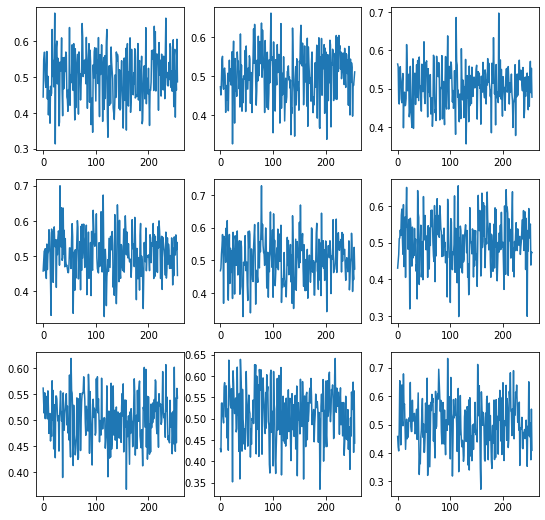

epoch-25; D_loss: -0.006993718445301056; G_loss: 0.12443629652261734


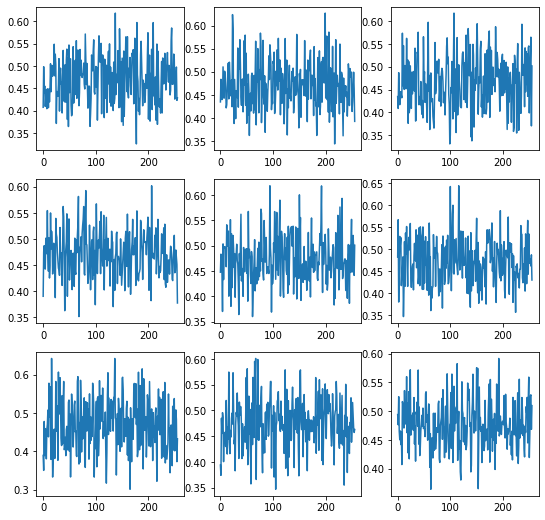

epoch-50; D_loss: -0.022916629910469055; G_loss: -0.08852694183588028


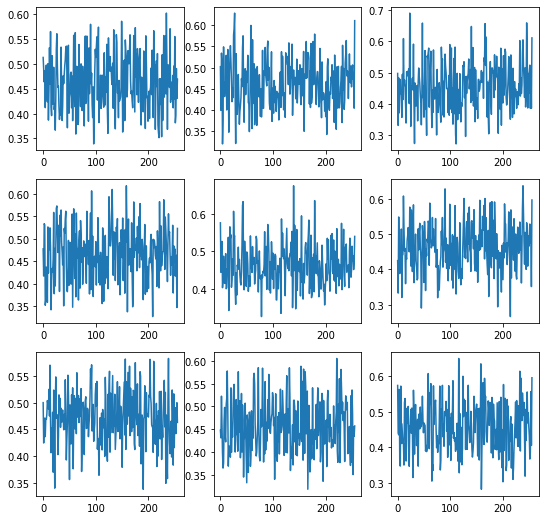

epoch-75; D_loss: -0.02244262769818306; G_loss: 0.0006741506513208151


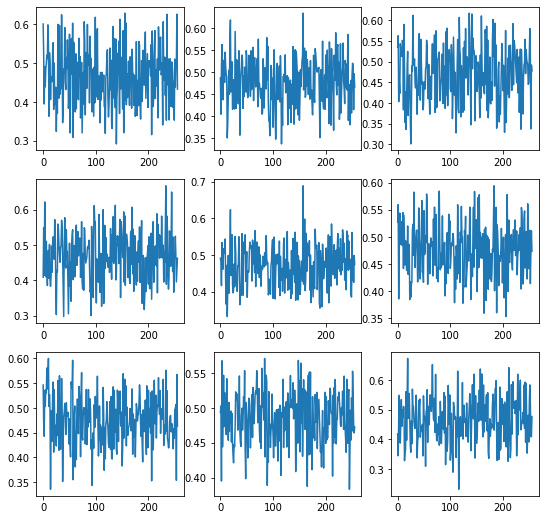

epoch-100; D_loss: -0.03457638993859291; G_loss: 0.011213903315365314


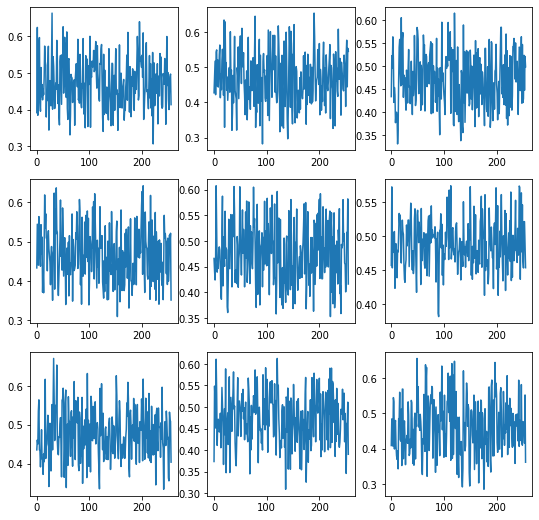

epoch-125; D_loss: -0.023863406851887703; G_loss: 0.006308068986982107


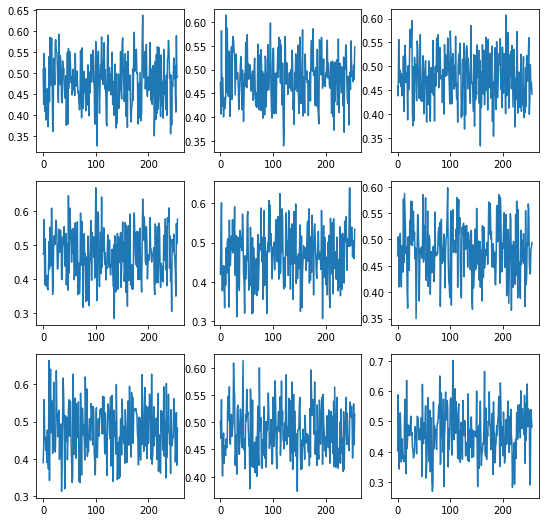

epoch-150; D_loss: -0.031274572014808655; G_loss: 0.050956230610609055


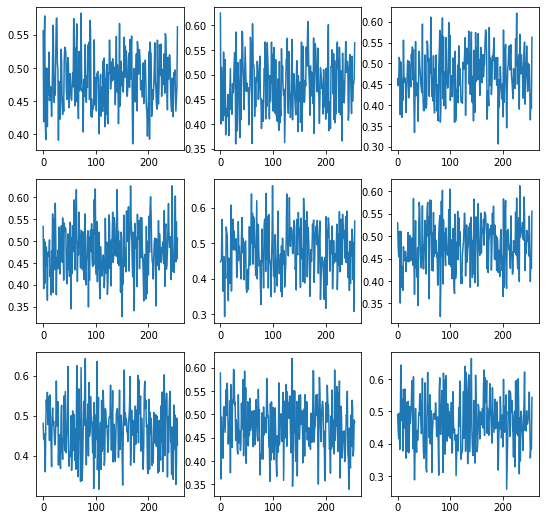

epoch-175; D_loss: -0.019675863906741142; G_loss: 0.030711084604263306


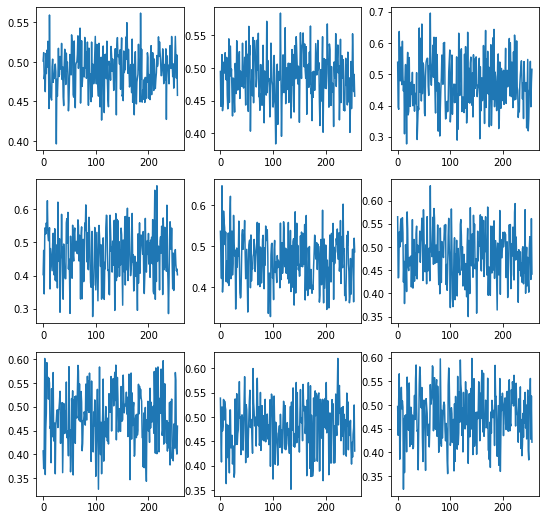

epoch-200; D_loss: -0.03253982961177826; G_loss: 0.0010800632881000638


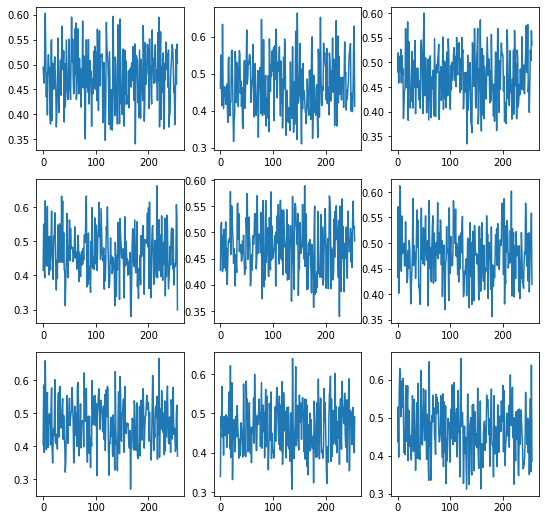

epoch-225; D_loss: -0.01671024039387703; G_loss: 0.00834315549582243


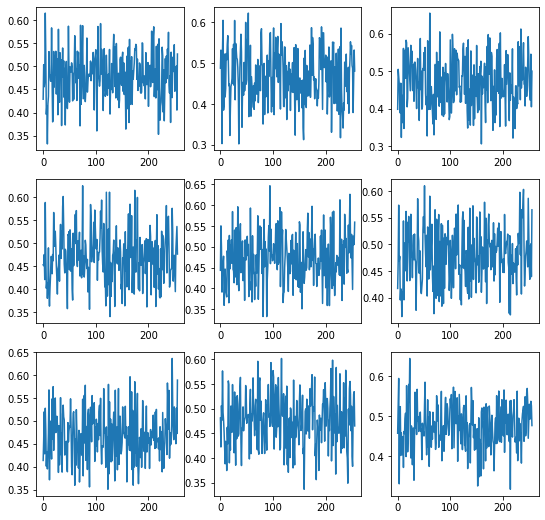

epoch-250; D_loss: -0.02616818994283676; G_loss: 0.02658325806260109


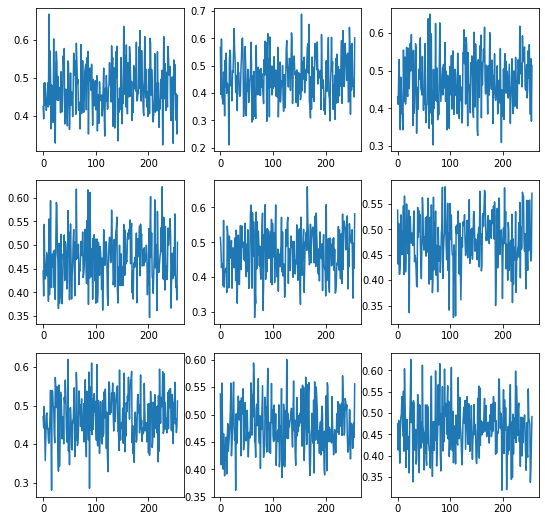

epoch-275; D_loss: -0.019361790269613266; G_loss: 0.011838856153190136


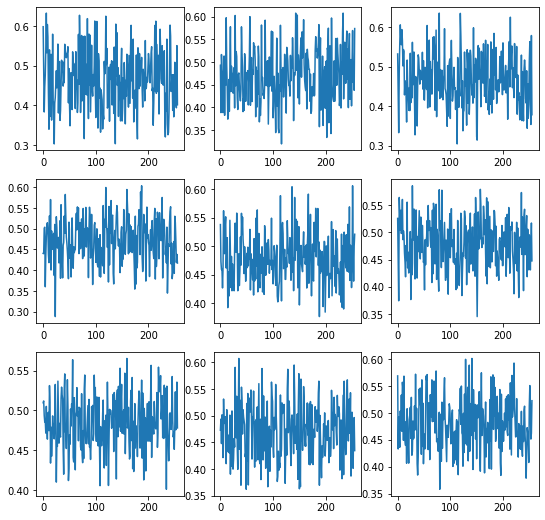

epoch-300; D_loss: -0.02229452319443226; G_loss: 0.011228984221816063


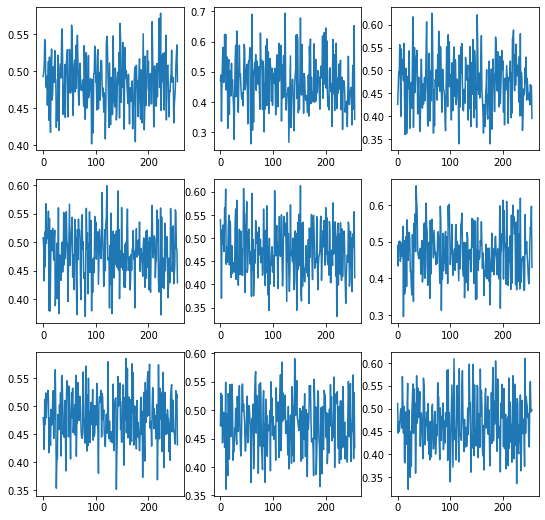

epoch-325; D_loss: -0.02079981565475464; G_loss: 0.018176846206188202


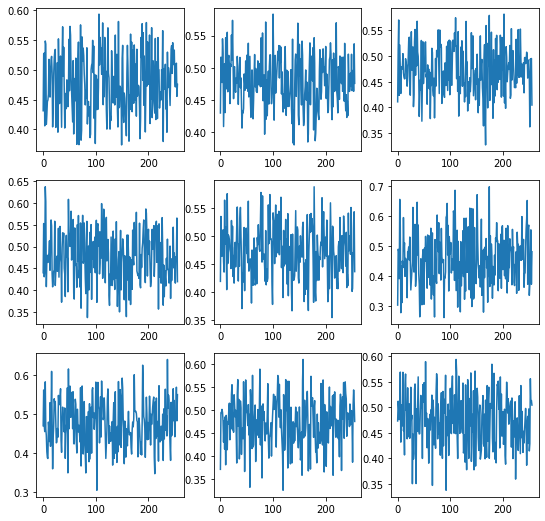

epoch-350; D_loss: -0.016342582181096077; G_loss: 0.017253141850233078


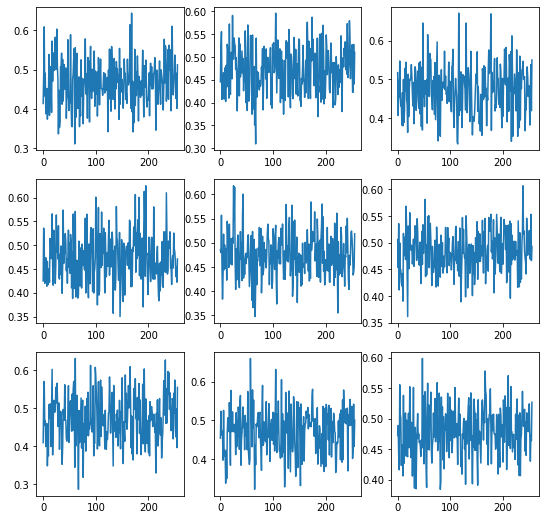

epoch-375; D_loss: -0.022334281355142593; G_loss: 0.01676313206553459


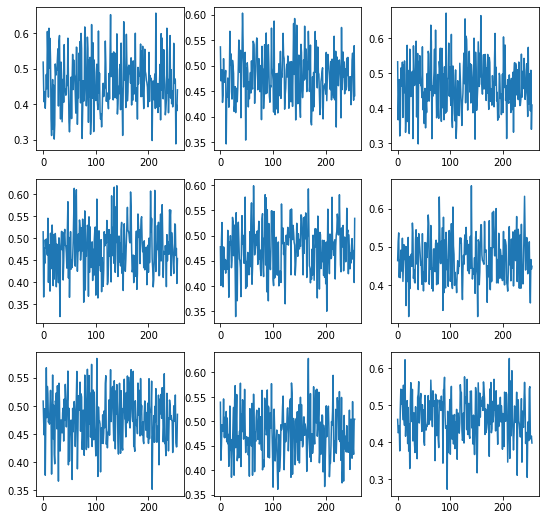

epoch-400; D_loss: -0.012683838605880737; G_loss: 0.021136341616511345


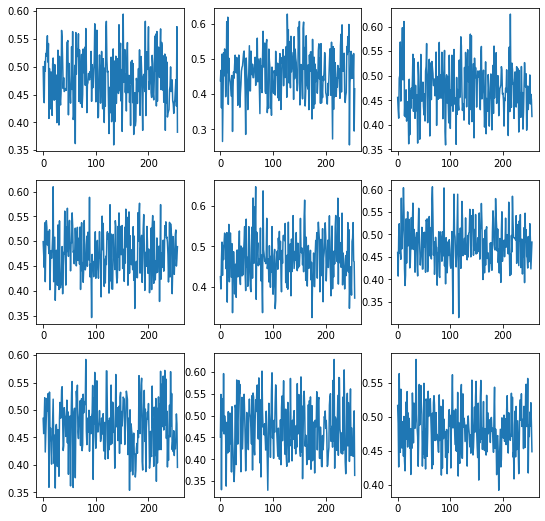

epoch-425; D_loss: -0.021678555756807327; G_loss: 0.018278731033205986


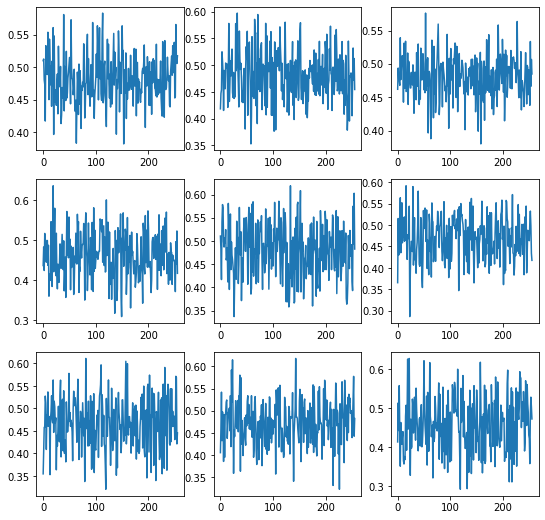

epoch-450; D_loss: -0.015858083963394165; G_loss: 0.009684281423687935


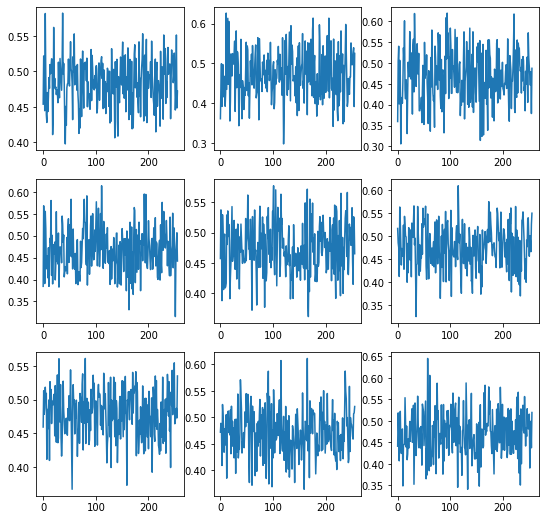

epoch-475; D_loss: -0.02246103435754776; G_loss: 0.015780866146087646


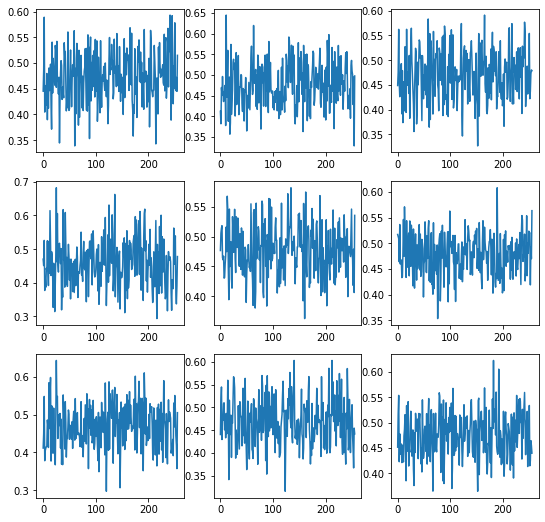

In [ ]:
generator = run_train(dataset, \
          latent_dim=LATENT_DIM, \
          sample_size=SAMPLE_SIZE, \
          learning_rate=LEARNING_RATE, \
          num_epochs=NUM_EPOCHS, \
          batch_size=BATCH_SIZE, \
          print_each=PRINT_EACH, \
          verbose=VERBOSE, \
          no_save=NO_SAVE)

In [14]:
generated_noises = np.array([generate_new_signal(generator)[0] for i in range(len(data))])

In [15]:
def get_random_signal(data):
    return data[np.random.choice(range(len(data)))]

def get_closest(signal, data):
    diffs = np.mean((data - signal) ** 2, axis=1)
    return data[np.argmin(diffs)]

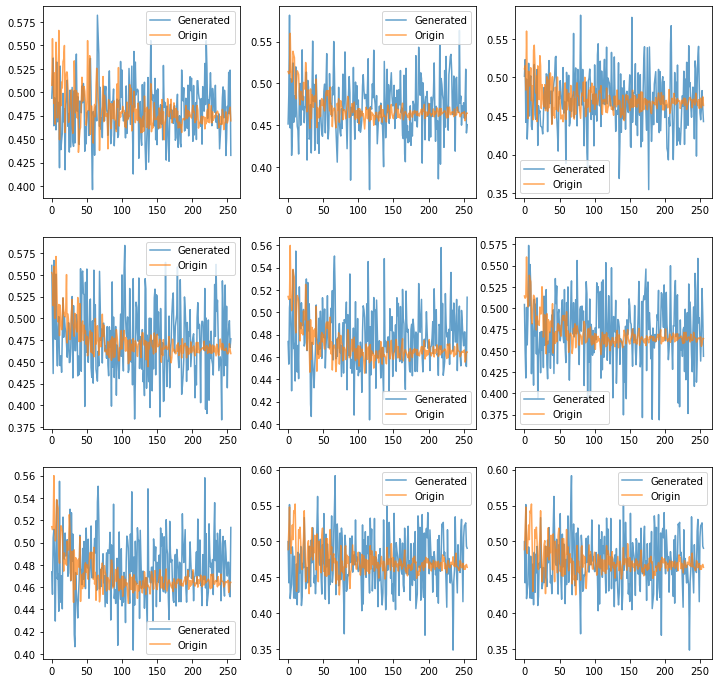

In [16]:
rows_num = 3
cols_num = 3
f, ax = plt.subplots(rows_num, cols_num, figsize=(12, 12))

for i in range(rows_num * cols_num):
    generated_noise = get_random_signal(generated_noises)
    closest_origin = get_closest(generated_noise, noises)
    ax[i // rows_num][i % cols_num].plot(generated_noise, alpha=0.7)
    ax[i // rows_num][i % cols_num].plot(closest_origin, alpha=0.7)
    ax[i // rows_num][i % cols_num].legend(['Generated', 'Origin'])
plt.show()

In [17]:
generated_noises = scaler.unscale(generated_noises)
generated_data = np.mean(data, axis=0) + generated_noises

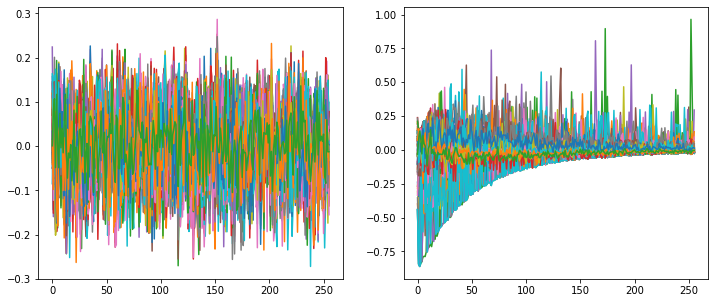

In [18]:
f, ax = plt.subplots(1, 2, figsize=(12, 5))
for noise in generated_noises:
    ax[0].plot(noise)
for noise in origin_noises:
    ax[1].plot(noise)

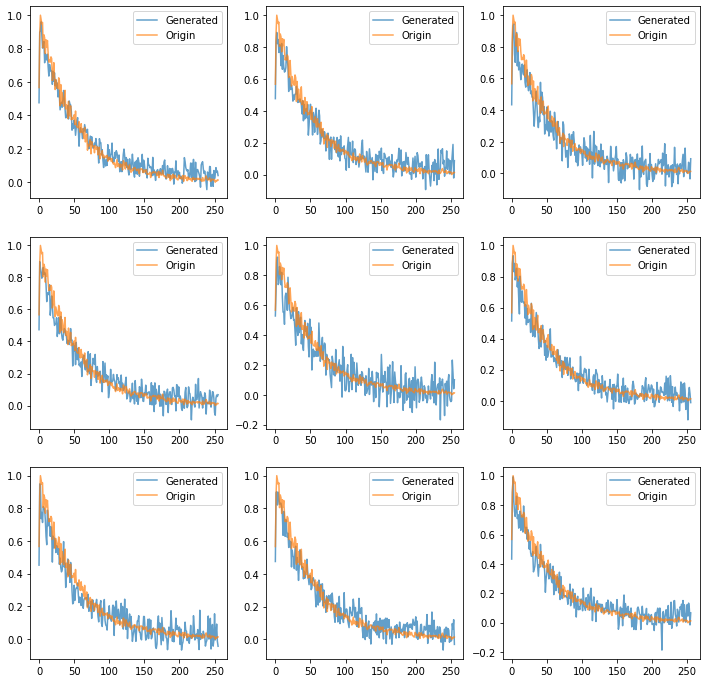

In [19]:
rows_num = 3
cols_num = 3
f, ax = plt.subplots(rows_num, cols_num, figsize=(12, 12))

for i in range(rows_num * cols_num):
    generated_signal = get_random_signal(generated_data)
    closest_origin = get_closest(generated_data, data)
    ax[i // rows_num][i % cols_num].plot(generated_signal, alpha=0.7)
    ax[i // rows_num][i % cols_num].plot(closest_origin, alpha=0.7)
    ax[i // rows_num][i % cols_num].legend(['Generated', 'Origin'])
plt.show()

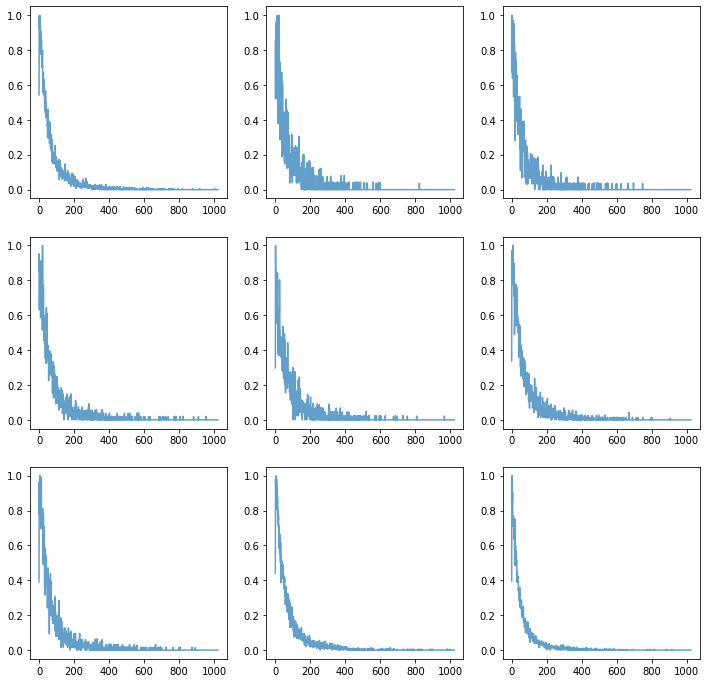

In [24]:
rows_num = 3
cols_num = 3
f, ax = plt.subplots(rows_num, cols_num, figsize=(12, 12))

for i in range(rows_num * cols_num):
#     generated_signal = generated_data)
#     closest_origin = get_closest(generated_data, data)
    ax[i // rows_num][i % cols_num].plot(get_random_signal(data), alpha=0.7)
#     ax[i // rows_num][i % cols_num].plot(closest_origin, alpha=0.7)
#     ax[i // rows_num][i % cols_num].legend(['Generated', 'Origin'])
plt.show()